# Оптимизация производственных расходов металлургического комбината

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import seaborn as sns

Посмотрим содержимое каждого файла и изучим статистику данных.

- Файл с данными измерения температуры "data_temp.csv"

In [2]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [3]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


Всего имеется 15907 записей. Пропущенные значения присутствуют в столбце "Температура". 

Посмотрим на данные:

In [4]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


In [5]:
data_temp.tail(10)

,key,Время замера,Температура
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


In [6]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Температура изменяется в диапазоне от 1191 до 1705 с медианой 1591 и средним 1591.8.

Посмотрим, имеются ли дублированные строки:

In [7]:
data_temp.duplicated().sum()

0

Построим диаграмму размаха по температуре:

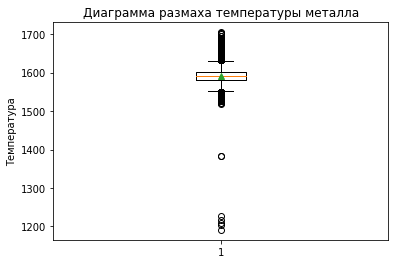

In [8]:
plt.boxplot(
            data_temp['Температура'].dropna(),
            showmeans=True
            )
plt.ylabel('Температура')
plt.title('Диаграмма размаха температуры металла')
plt.show()

В данных по температуре имеются выбросы снизу, причем отличие температуры от нормальной, составляющей ~1600, довольно существенное.

Посмотрим, сколько записей о различных партиях имеется в файле:

In [9]:
len(data_temp['key'].unique())

3216

Заменим тип данных в столбце "Время замера" на datetime:

In [10]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

Cоздадим таблицу с последней актуальной температурой для каждой партии металла:

In [11]:
data_last_temp = data_temp.loc[data_temp['Время замера'].isin(
    data_temp.groupby(['key']).agg({'Время замера':'max'}).reset_index(drop=True)['Время замера'])]\
    [['key','Температура']].reset_index(drop=True)

In [12]:
data_last_temp

,key,Температура
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0
...,...,...
3211,3237,NaN
3212,3238,NaN
3213,3239,NaN
3214,3240,NaN


Посмотрим, сколько пропущенных значений температуры имеется:

In [13]:
data_last_temp['Температура'].isna().sum()

739

Удалим пропущенные значения конечной температуры:

In [14]:
data_last_temp = data_last_temp.dropna()

Переименуем название температуры:

In [15]:
data_last_temp.columns = ['key', 'Конечная температура']

Создадим таблицу с начальной температурой:

In [16]:
data_first_temp = data_temp.loc[data_temp['Время замера'].isin(
    data_temp.groupby(['key']).agg({'Время замера':'min'}).reset_index(drop=True)['Время замера'])]\
    [['key','Температура']].reset_index(drop=True)

In [17]:
data_first_temp

,key,Температура
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0
...,...,...
3211,3237,1569.0
3212,3238,1584.0
3213,3239,1598.0
3214,3240,1617.0


Посмотрим на пропущенные значения:

In [18]:
data_first_temp.isna().sum()

key            0
Температура    0
dtype: int64

Переименуем температуру:

In [19]:
data_first_temp.columns = ['key', 'Начальная температура']

Объединим начальную и конечную температуру:

In [20]:
data_first_last_temp = data_first_temp.merge(data_last_temp, on='key')

In [21]:
data_first_last_temp 

,key,Начальная температура,Конечная температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


- Файл с данными электродов "data_arc"

In [22]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [23]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Всего имеется 14876 записей, 5 столбцов. Пропущенные значения в файле отсутствуют.

Посмотрим на начало файла данных, случайные строки и конец файла:

In [24]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [25]:
data_arc.sample(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
8800,1915,2019-07-15 20:43:45,2019-07-15 20:44:19,0.145208,0.096683
7782,1687,2019-07-02 14:07:44,2019-07-02 14:15:35,1.632620,1.345000
8784,1910,2019-07-15 14:13:48,2019-07-15 14:18:52,1.368438,0.910506
7356,1598,2019-06-29 19:49:36,2019-06-29 19:50:57,0.364738,0.250985
2078,447,2019-05-19 21:09:12,2019-05-19 21:11:49,0.536420,0.381936
6795,1476,2019-06-25 17:07:55,2019-06-25 17:10:34,0.642920,0.440609
6112,1332,2019-06-20 05:52:54,2019-06-20 05:54:58,0.542053,0.368303
3196,692,2019-05-28 23:24:24,2019-05-28 23:26:16,0.381262,0.270166
13823,2998,2019-08-24 05:39:20,2019-08-24 05:41:05,0.485699,0.322884
8714,1895,2019-07-09 20:31:26,2019-07-09 20:32:29,0.198764,0.157267


In [26]:
data_arc.tail(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14866,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.411601,0.274390
14867,3240,2019-09-01 02:40:55,2019-09-01 02:43:28,0.521811,0.378517
14868,3240,2019-09-01 03:08:38,2019-09-01 03:11:08,0.518065,0.528780
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.983723,0.884585
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.548882,0.416994
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


In [27]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Активная мощность изменяется в диапазоне от 0.03 до 3.73 со средним 0.67 и медианой 0.55. Реактивная мощность изменяется от 0.02 до 2.67, среднее 0.5 и медиана 0.41.

Посмотрим, сколько записей о различных партиях имеется в файле:

In [28]:
len(data_arc['key'].unique())

3214

Посмотрим, сколько имеется значений отрицательной реактивной мощности:

In [29]:
(data_arc['Реактивная мощность'] < 0).sum()

1

Будем считать значение "-715" ошибочным и заменим его на среднее по данной партии:

In [30]:
data_arc.loc[data_arc['Реактивная мощность'] < 0, 'Реактивная мощность'] =  data_arc.loc[
        data_arc['key']==data_arc.loc[data_arc.loc[data_arc['Реактивная мощность'] < 0].index[0], 'key'], 
    'Реактивная мощность'].where(data_arc['Реактивная мощность'] > 0).mean()

Построим диаграммы размаха по мощности:

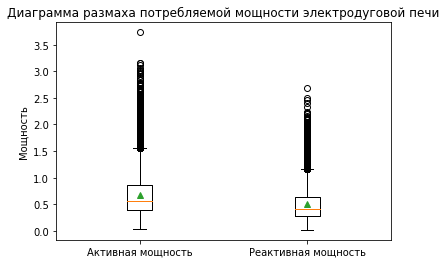

In [31]:
plt.boxplot(
            [data_arc['Активная мощность'],
            data_arc['Реактивная мощность']],
            labels = ['Активная мощность', 'Реактивная мощность'], showmeans=True
            )
plt.ylabel('Мощность')
plt.title('Диаграмма размаха потребляемой мощности электродуговой печи')
plt.show()

В данных по мощности отсутствуют выбросы "снизу", медианное значение довольно близко к среднему, при этом оба распределения смещены вправо. 

Проверим данные на наличие дублированных строк:

In [32]:
data_arc.duplicated().sum()

0

Преобразуем дату в тип datetime:

In [33]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [34]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

Добавим столбец со временем нагрева в минутах:

In [35]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой']-data_arc['Начало нагрева дугой']) / pd.Timedelta(minutes=1)

In [36]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,3.800000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,3.083333
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,2.866667
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,6.083333
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,2.466667


Добавим столбец с полной мощностью и рассчитаной затраченной энергией:

In [37]:
data_arc['Полная мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2) ** 0.5

In [38]:
data_arc['Затраченная энергия'] = data_arc['Полная мощность'] *  data_arc['Время нагрева']

In [39]:
data_arc_work = data_arc.groupby('key').agg({'Затраченная энергия':'sum'})
data_arc_work

,Затраченная энергия
key,
1,24.039629
2,14.687226
3,8.751113
4,13.281855
5,19.985633
...,...
3237,15.972271
3238,9.264456
3239,16.884462


- Файл с данными объема подачи сыпучих материалов "data_bulk.csv"

In [40]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [41]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Пропуски отсутствуют только в столбце "key", в остальных столбцах они имеются.

Посмотрим на данные:

In [42]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [43]:
data_bulk.sample(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2345,2430,NaN,NaN,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,NaN,NaN,NaN
1276,1327,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.0,NaN,136.0,216.0
893,929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.0,NaN
382,408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,156.0,152.0
283,301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313.0,NaN,254.0,204.0
2370,2457,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.0,NaN,89.0,206.0
627,657,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.0,NaN,132.0,104.0
3050,3159,NaN,NaN,194.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,418.0,NaN,250.0,NaN
1958,2026,NaN,NaN,NaN,NaN,NaN,106.0,NaN,NaN,NaN,NaN,74.0,NaN,NaN,249.0,NaN
211,228,NaN,NaN,153.0,NaN,NaN,95.0,NaN,NaN,NaN,NaN,NaN,256.0,NaN,154.0,204.0


In [44]:
data_bulk.tail(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3119,3232,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,92.0,204.0
3120,3233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,114.0,204.0
3121,3234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.0,204.0
3122,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,118.0,206.0
3123,3236,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.0,NaN,132.0,208.0
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [45]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Значения признаков меняются в широком диапазоне. Медиана и среднее признаков bulk находятся довольно близко, при этом почти все распределения bulk (кроме bulk 10) смещены вправо. Отрицательные значения отсутствуют. Чаще всего используются материалы Bulk 3, 4, 6, 12, 14, 15.

Посмотрим, имеются ли дублированные строки:

In [46]:
data_bulk.duplicated().sum()

0

Посмотрим, сколько записей о различных партиях имеется в файле:

In [47]:
len(data_bulk['key'].unique())

3129

Заменим пропущенные значения, которые могут говорить об отсутствии подачи материала, на нули.

In [48]:
data_bulk = data_bulk.fillna(0)

- Файл с данными о времени подачи сыпучих материалов "data_bulk_time.csv"

In [49]:
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

In [50]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Всего имеется 3129 записей. Пропущенных значений нет только в столбце "key", во всех остальных они имеются. 

Посмотрим на данные:

In [51]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


In [52]:
data_bulk_time.tail(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3119,3232,NaN,NaN,2019-08-31 20:03:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 19:58:36,NaN,2019-08-31 19:58:36,2019-08-31 19:58:36
3120,3233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 20:26:21,NaN,2019-08-31 20:26:21,2019-08-31 20:26:21
3121,3234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 20:58:45,2019-08-31 20:58:45
3122,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 21:29:26,NaN,2019-08-31 21:29:26,2019-08-31 21:29:26
3123,3236,NaN,NaN,2019-08-31 22:20:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:11:55,NaN,2019-08-31 22:11:55,2019-08-31 22:11:55
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


Посмотрим, имеются ли дублированные строки:

In [53]:
data_bulk_time.duplicated().sum()

0

Посмотрим, сколько записей о различных партиях имеется в файле:

In [54]:
len(data_bulk_time['key'].unique())

3129

Пропуски данных в файле не заменены, т.к. использовать эти данные в дальнейшей работе не планируется.

- Файл с данными продувки сплава газом "data_gas.csv"

In [55]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [56]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Всего имеется 3239 записей. Пропущенные значения отсутствуют.

Посмотрим на данные:

In [57]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [58]:
data_gas.tail(10)

,key,Газ 1
3229,3232,8.630453
3230,3233,7.366606
3231,3234,9.110702
3232,3235,5.710729
3233,3236,6.958647
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [59]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Данные по газу изменяются почти от нуля (0.008) до 78. Медиана и среднее находятся близко и составляют 9.8 и 11. Данные смещены вправо.

Посмотрим, имеются ли дублированные строки:

In [60]:
data_gas.duplicated().sum()

0

Посмотрим, сколько записей о различных партиях имеется в файле:

In [61]:
len(data_gas['key'].unique())

3239

- Файл с данными объема проволочных материалов "data_wire.csv"

In [62]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [63]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Всего имеется 3081 запись. Пропуски отсутствуют только в столбце "key".

In [64]:
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
data_wire.tail(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,15.069600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,107.147033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,110.160957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,125.099525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,101.162880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Наиболее часто используемыми проволочными материалами являются wire 1, 2. Остальные применяются относительно редко. Данные признаков изменяются в широком диапазоне, при этом среднее и медиана находятся довольно близко. Отрицательные значения отсутствуют.

Посмотрим, имеются ли дублированные строки:

In [67]:
data_wire.duplicated().sum()

0

Посмотрим, сколько записей о различных партиях имеется в файле:

In [68]:
len(data_wire['key'].unique())

3081

Т.к. пропущенные значения могут говорить об отсутствии подачи материала, заменим такие значения на нули:

In [69]:
data_wire = data_wire.fillna(0)

- Файл с данными о времени подачи проволочных материалов "data_wire_time.csv"

In [70]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [71]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Всего имеется 3081 запись. Пропуски отсутствуют только в столбце "key".

Посмотрим на данные:

In [72]:
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
data_wire_time.tail(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3071,3232,2019-08-31 20:02:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3072,3233,2019-08-31 20:31:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3073,3234,2019-08-31 21:03:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3074,3235,2019-08-31 21:33:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,2019-08-31 22:19:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Пропуски данных в файле не заменены, т.к. использовать эти данные в дальнейшей работе не планируется.

Объединим полученные таблицы в одну по номеру партии:

In [74]:
data_combined = data_arc_work.merge(data_first_last_temp,  on='key').\
    merge(data_bulk, on='key').\
    merge(data_gas, on='key').\
    merge(data_wire, on='key')

In [75]:
data_combined.columns = ['key', 'current_work', 'initial_temp',
       'last_temp', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
       'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
       'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas', 'wire_1', 'wire_2',
       'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

Удалим из общей таблицы признак "key", ненужный при создании моделей, а также "wire_5", т.к. в этом столбце остались только нулевые значения: 

In [76]:
data_combined = data_combined.drop(columns=['key', 'wire_5'], axis=1)

Для того, чтобы проверить признаки на мультиколлинеарность, посмотрим на их корреляцию и построим тепловую карту:

In [77]:
data_combined.corr()

,current_work,initial_temp,last_temp,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
current_work,1.000000,-0.333024,0.275018,0.066623,0.018626,0.062171,-0.035293,-0.017001,0.127996,0.042591,-0.008456,-0.001879,-0.001792,0.066153,0.480239,0.160653,0.440997,0.309566,0.319201,0.005963,0.015851,0.006238,0.031639,0.036995,0.006148,0.001013,-0.012310
initial_temp,-0.333024,1.000000,0.252443,0.072331,0.119802,-0.104394,0.144775,0.068389,-0.096951,0.074729,-0.009320,-0.026216,0.035408,-0.087791,-0.058495,0.018606,-0.131024,-0.040349,0.037341,0.209444,-0.086089,-0.000178,0.064991,0.019884,0.044771,-0.023261,0.004310
last_temp,0.275018,0.252443,1.000000,-0.075206,-0.082454,-0.035977,0.187970,-0.028355,-0.181816,-0.107275,-0.026587,-0.016075,0.061350,-0.114753,0.267424,-0.010920,0.114617,0.266414,0.059160,0.317575,-0.206672,-0.047537,-0.159719,-0.084034,-0.137262,-0.010767,-0.027488
bulk_1,0.066623,0.072331,-0.075206,1.000000,0.224701,-0.011628,0.041846,0.060429,-0.003630,0.237213,-0.005725,-0.019756,-0.023187,-0.037892,0.325771,-0.010279,0.207718,-0.000800,0.234141,0.013682,-0.009229,0.020271,0.146301,0.148561,0.083443,-0.019535,0.011066
bulk_2,0.018626,0.119802,-0.082454,0.224701,1.000000,-0.046888,0.040792,0.360302,-0.029984,0.679356,-0.001545,-0.005333,-0.018015,0.001479,-0.098962,-0.005592,-0.140952,-0.105693,0.217415,-0.169477,-0.039058,0.223202,0.699342,0.558889,0.431737,-0.005273,-0.006842
bulk_3,0.062171,-0.104394,-0.035977,-0.011628,-0.046888,1.000000,-0.295431,-0.006801,0.065284,-0.033480,0.020824,0.011337,-0.085186,-0.007445,0.018371,-0.013389,0.010772,-0.012860,0.059628,0.039637,0.095723,0.005780,-0.040526,0.007113,-0.019448,0.004846,0.004621
bulk_4,-0.035293,0.144775,0.187970,0.041846,0.040792,-0.295431,1.000000,0.028348,-0.251562,0.045893,-0.013187,-0.002940,-0.084746,-0.119529,0.105791,0.003209,-0.090602,0.101514,0.017578,0.297591,-0.268142,-0.039219,0.034421,-0.011417,0.033829,0.007830,-0.058138
bulk_5,-0.017001,0.068389,-0.028355,0.060429,0.360302,-0.006801,0.028348,1.000000,-0.021852,0.288338,-0.002443,-0.008431,-0.028480,-0.015840,-0.072758,-0.008841,-0.065890,-0.067190,0.086902,-0.013493,-0.013794,0.070916,0.262763,0.204819,0.172141,-0.008337,-0.010817
bulk_6,0.127996,-0.096951,-0.181816,-0.003630,-0.029984,0.065284,-0.251562,-0.021852,1.000000,-0.025099,-0.008334,-0.028762,-0.097157,0.196733,-0.112902,0.042632,0.177490,-0.109316,0.139625,-0.235793,0.204627,-0.046518,-0.025915,-0.020223,-0.012437,-0.028440,-0.013335
bulk_7,0.042591,0.074729,-0.107275,0.237213,0.679356,-0.033480,0.045893,0.288338,-0.025099,1.000000,-0.001355,-0.004675,-0.015793,-0.004910,-0.017742,-0.004902,-0.076388,-0.090099,0.198311,-0.143267,-0.000631,0.156626,0.740572,0.456101,0.372250,-0.004623,-0.005998


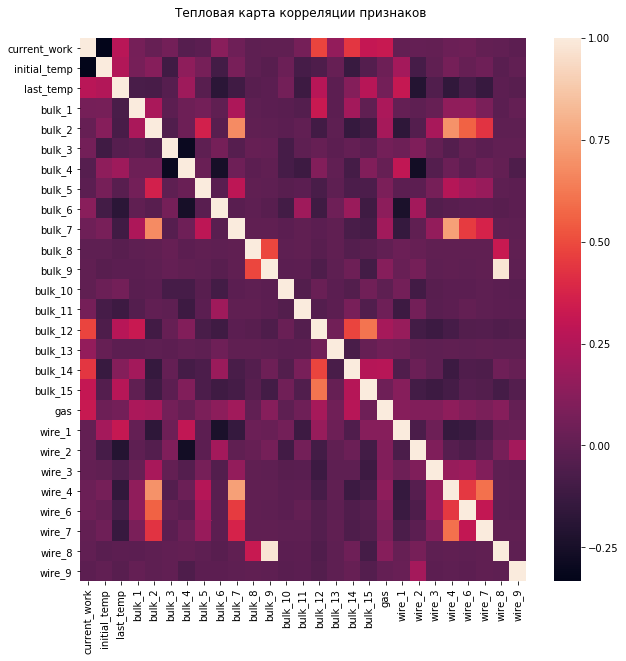

In [78]:
plt.figure(figsize = (10, 10))
sns.heatmap(data_combined.corr(), xticklabels=True, yticklabels=True)
plt.title('Тепловая карта корреляции признаков \n')
plt.show()

Из всех признаков наиболее сильно скоррелированы между собой "bulk_9" и "wire_8". Удалим один их этих признаков:

In [79]:
data_combined = data_combined.drop('wire_8', axis=1)

### Вывод

На данном этапе были загружены и изучены все 7 предоставленных файлов данных. Были удалены пропущенные и некорректные значения, преобразованы типы данных object в datetime. Была рассмотрена статистика по данным. Активная и реактивная мощность были преобразованы в затраченную энергию на нагрев стали. Далее затраченная энергия, разделенная по времени, была сгруппирована и просуммирована по партиям металла. Также на данном этапе все признаки были объединены в общую таблицу и проверены на мультиколлинеарность. Были удалены 2 признака ("wire_5", "wire_8"). В дальнейшей работе не используются данные из файлов "data_bulk_time.csv", "data_wire_time.csv", т.к. нам не важно время введения добавок в расплав.

## Создание моделей

- Создадим функцию для разделения данных на обучающие и тестовые:

In [80]:
def data_split(data):
    features = data.drop('last_temp', axis=1)
    target = data['last_temp']
    features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=1234)
    return features_train, features_test, target_train, target_test

In [81]:
features_train, features_test, target_train, target_test = data_split(data_combined)

- Создадим функцию для масштабирования признаков:

In [82]:
def data_scaler(data_train, data_test):
    scaler = StandardScaler()
    scaler.fit(data_train)
    features_train = scaler.transform(data_train)
    features_test = scaler.transform(data_test)
    return features_train, features_test

In [83]:
features_train, features_test = data_scaler(features_train, features_test)

- Создадим функцию, вычисляющую целевую метрику МАЕ для использования в GridSearchCV:

In [84]:
def mae_calc(features, target):
    mae = (mean_absolute_error(features, target))
    return mae

In [85]:
my_scorer = make_scorer(mae_calc, greater_is_better=False)

- Создадим таблицу для сохранения финальных результатов метрик моделей:

In [86]:
model_results = pd.DataFrame(columns=['mae_train', 'mae_test'], 
                             index=['linear_regression', 'tree', 'random_forest', 'LightGBM', 'CatBoost'])

- Создадим и проверим предсказания константной модели, чтобы иметь представление о том, насколько полученная нами метрика адекватна:

In [87]:
predictions_dummy = pd.Series(target_train.mean(), index=target_train.index)

In [88]:
print('MAE константной модели:', round(mean_absolute_error(target_train, predictions_dummy), 3))

MAE константной модели: 8.224


### Проверка важности признаков

Чтобы улучшить качество предсказания моделей, произведем проверку важности признаков для случайного леса, LightGBM, CatBoost и по её результатам удалим лишние признаки, вносящие "шум" в работу моделей. Для этого создадим и обучим модели со стандартными гиперпараметрами и сравним значения feature_importances:

- Случайный лес

In [89]:
model_random_forest = RandomForestRegressor(
    random_state=12345,
    n_estimators=10,
    n_jobs=-1)

In [90]:
model_random_forest.fit(features_train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=12345, verbose=0,
                      warm_start=False)

In [91]:
feature_importances = pd.DataFrame(
    model_random_forest.feature_importances_*100,
    index=data_combined.drop('last_temp', axis=1).columns,
    columns=['random_forest'])

- CatBoost

In [92]:
model_catboost = CatBoostRegressor(verbose=False)

In [93]:
model_catboost.fit(features_train, target_train)

In [94]:
feature_importances['catboost'] = model_catboost.get_feature_importance()

- LightGBM

In [95]:
params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': 'mae',
    'verbose': 0
    }

In [96]:
lgb_train = lgb.Dataset(features_train, target_train)

In [97]:
lgb_test = lgb.Dataset(features_test, target_test)

In [98]:
model_gbm = lgb.train(
    params, 
    lgb_train, 
    valid_sets=lgb_test, 
    verbose_eval=False
)

In [99]:
feature_importances['lgbm'] = model_gbm.feature_importance() * 100 / 3000 #приводим значения к диапазону 0-100%

Посмотрим на итоговую таблицу и построим диаграмму для всех трех моделей:

In [100]:
feature_importances

,random_forest,catboost,lgbm
current_work,20.316909,24.486686,13.600000
initial_temp,21.912841,25.046395,15.066667
bulk_1,1.380353,2.616547,1.700000
bulk_2,0.024090,0.048910,0.000000
bulk_3,2.119637,2.524895,4.766667
bulk_4,3.225281,2.321765,3.433333
bulk_5,0.116884,0.119037,0.666667
bulk_6,6.258283,5.574220,4.500000
bulk_7,5.351282,1.949351,0.000000
bulk_8,0.009358,0.002169,0.000000


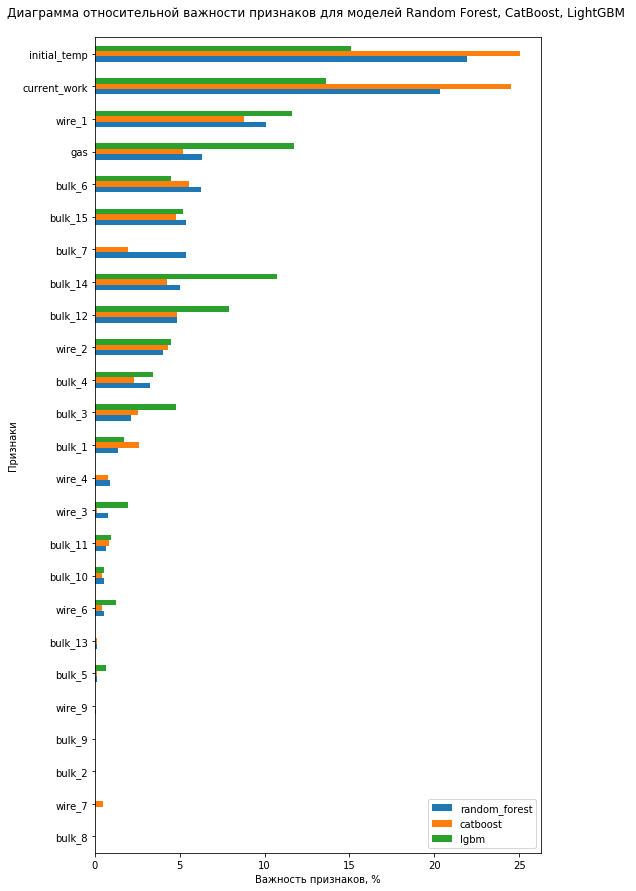

In [101]:
feature_importances.sort_values(by='random_forest').plot(kind='barh', rot=0, figsize=(8,15))
plt.ylabel('Признаки')
plt.xlabel('Важность признаков, %')
plt.title('Диаграмма относительной важности признаков для моделей Random Forest, CatBoost, LightGBM \n')
plt.show()

Первая четверка признаков (начальная температура, затраченная энергия, wire 1, подача газа) по важности одинаковая для всех моделей. Остальные признаки разные модели оценивают немного по-разному. Последние 7 признаков имеют важность около нуля. В дальнейшем для каждой модели будем брать только те признаки, значимость которых выше определенного порога.

### Обучение моделей

Для моделей Random Forest, LightGBM, CatBoost будем брать признаки с относительной важностью более 1% (такое значение показало лучшее MAE на обучающей выборке опытным путем). Затем для каждой модели будем разделять выборку на обучающую и тестовую и масштабировать признаки. Далее найдем наилучшие гиперпараметры через поиск GridSearchCV с кроссвалидацией (folds=3), обучим модели с найденными гиперпараметрами и проверим на тестовых данных.

In [102]:
imp_cutoff = 1 # отсечка по важности признаков

- Случайный лес

In [103]:
data_combined_forest = data_combined.loc[:,feature_importances[feature_importances['random_forest'] > imp_cutoff].index]

In [104]:
data_combined_forest = data_combined_forest.merge(data_combined.loc[:,['last_temp', 'current_work']], on='current_work')

In [105]:
features_train, features_test, target_train, target_test = data_split(data_combined_forest)

In [106]:
features_train, features_test = data_scaler(features_train, features_test)

In [107]:
model_random_forest = RandomForestRegressor(random_state=12345)

In [108]:
random_forest_param = {'n_estimators': range(20,101,20),        
                       'max_depth': range(2,15,2),     
                       'min_samples_leaf': [2]
                      }

In [109]:
grid_random_forest = GridSearchCV(model_random_forest, random_forest_param, cv=3, scoring=my_scorer, n_jobs=-1)

In [110]:
%%time
grid_random_forest.fit(features_train, target_train)

CPU times: user 35.6 s, sys: 20.5 ms, total: 35.6 s
Wall time: 36.2 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=-1,
            

In [111]:
print('Значение MAE на обучающей выборке:', round(abs(grid_random_forest.best_score_), 3))

Значение MAE на обучающей выборке: 6.316


In [112]:
print('Найденные гиперпараметры:', grid_random_forest.best_params_)

Найденные гиперпараметры: {'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 100}


Сохраняем результаты в итоговую таблицу:

In [113]:
model_results.loc['random_forest', 'mae_train'] = round(abs(grid_random_forest.best_score_), 3)

Проверяем модель на тестовых данных:

In [114]:
model_random_forest = RandomForestRegressor(
    random_state=12345, 
    n_estimators=grid_random_forest.best_params_['n_estimators'], 
    max_depth=grid_random_forest.best_params_['max_depth'], 
    min_samples_leaf=grid_random_forest.best_params_['min_samples_leaf'],
    n_jobs=-1)

In [115]:
model_random_forest.fit(features_train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=12345, verbose=0,
                      warm_start=False)

In [116]:
predictions_forest = model_random_forest.predict(features_test)

In [117]:
print('Значение MAE на тестовой выборке:', round(mean_absolute_error(target_test, predictions_forest), 3))

Значение MAE на тестовой выборке: 5.817


In [118]:
model_results.loc['random_forest', 'mae_test'] = round(mean_absolute_error(target_test, predictions_forest),3)

- Линейная регрессия

In [119]:
features_train, features_test, target_train, target_test = data_split(data_combined)

In [120]:
features_train, features_test = data_scaler(features_train, features_test)

In [121]:
model_linear = LinearRegression()

In [122]:
grid_linear = GridSearchCV(model_linear, {}, cv=3, scoring=my_scorer)

In [123]:
grid_linear.fit(features_train, target_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring=make_scorer(mae_calc, greater_is_better=False), verbose=0)

In [124]:
print('Значение MAE на обучающей выборке:', round(abs(grid_linear.best_score_), 3))

Значение MAE на обучающей выборке: 6.644


In [125]:
model_results.loc['linear_regression', 'mae_train'] = round(abs(grid_linear.best_score_), 3)

Проверяем на тестовых данных:

In [126]:
model_linear = LinearRegression()

In [127]:
model_linear.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [128]:
predictions_linear = model_linear.predict(features_test)

In [129]:
print('Значение MAE на тестовой выборке:', round(mean_absolute_error(target_test, predictions_linear), 3))

Значение MAE на тестовой выборке: 6.303


In [130]:
model_results.loc['linear_regression', 'mae_test'] = round(mean_absolute_error(target_test, predictions_linear),3)

- Решающее дерево

In [131]:
features_train, features_test, target_train, target_test = data_split(data_combined)

In [132]:
features_train, features_test = data_scaler(features_train, features_test)

In [133]:
model_decision_tree = DecisionTreeRegressor(random_state=12345)

In [134]:
decision_tree_param = {'max_depth': range(2,11), 
                       'max_leaf_nodes': range(2,40,2)
                      }

In [135]:
grid_decision_tree = GridSearchCV(model_decision_tree, decision_tree_param, cv=3, scoring=my_scorer)

In [136]:
%%time
grid_decision_tree.fit(features_train, target_train)

CPU times: user 3.46 s, sys: 3.17 ms, total: 3.47 s
Wall time: 3.51 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=12345,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(2, 11),
                         'max_leaf_nodes': range(2, 40, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=m

In [137]:
print('Значение MAE на обучающей выборке:', round(abs(grid_decision_tree.best_score_), 3))

Значение MAE на обучающей выборке: 7.296


In [138]:
print('Найденные гиперпараметры:', grid_decision_tree.best_params_)

Найденные гиперпараметры: {'max_depth': 7, 'max_leaf_nodes': 32}


In [139]:
model_results.loc['tree', 'mae_train'] = round(abs(grid_decision_tree.best_score_), 3)

Проверяем на тестовых данных:

In [140]:
model_decision_tree = DecisionTreeRegressor(
    random_state=12345,
    max_depth=grid_decision_tree.best_params_['max_depth'],
    max_leaf_nodes=grid_decision_tree.best_params_['max_leaf_nodes'],
    criterion='mae')

In [141]:
model_decision_tree.fit(features_train, target_train)

DecisionTreeRegressor(criterion='mae', max_depth=7, max_features=None,
                      max_leaf_nodes=32, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [142]:
predictions_tree = model_decision_tree.predict(features_test)

In [143]:
print('Значение MAE на тестовой выборке:', round(mean_absolute_error(target_test, predictions_tree), 3))

Значение MAE на тестовой выборке: 6.251


In [144]:
model_results.loc['tree', 'mae_test'] = round(mean_absolute_error(target_test, predictions_tree), 3)

- LightGBM

In [145]:
data_combined_lgb = data_combined.loc[:,feature_importances[feature_importances['lgbm'] > imp_cutoff].index]

In [146]:
data_combined_lgb = data_combined_lgb.merge(data_combined.loc[:,['last_temp', 'current_work']], on='current_work')

In [147]:
features_train, features_test, target_train, target_test = data_split(data_combined_lgb)

In [148]:
features_train, features_test = data_scaler(features_train, features_test)

In [149]:
lgb_train = lgb.Dataset(features_train, target_train)

In [150]:
lgb_test = lgb.Dataset(features_test, target_test)

In [151]:
gridParams = {
    'n_estimators': [73], 
    'max_depth': range(5,21), 
    'learning_rate': [0.05],
    'reg_alpha': [0.02],
    'reg_lambda': [0.04]
}

In [152]:
gbm = lgb.LGBMRegressor(n_jobs=-1)

In [153]:
grid_gbm = GridSearchCV(gbm, gridParams, cv=3, scoring=my_scorer, n_jobs=-1)

In [154]:
%%time
grid_gbm.fit(features_train, target_train)

CPU times: user 4min 15s, sys: 1.66 s, total: 4min 16s
Wall time: 4min 18s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05], 'max_depth': range(5, 21),
                         'n_estimators': [73], 'reg_alpha': [0.02],
                         'r

In [155]:
print('Значение MAE на обучающей выборке:', round(abs(grid_gbm.best_score_), 3))

Значение MAE на обучающей выборке: 6.328


In [156]:
print('Найденные гиперпараметры:', grid_gbm.best_params_)

Найденные гиперпараметры: {'learning_rate': 0.05, 'max_depth': 19, 'n_estimators': 73, 'reg_alpha': 0.02, 'reg_lambda': 0.04}


In [157]:
model_results.loc['LightGBM', 'mae_train'] = round(abs(grid_gbm.best_score_), 3)

Проверяем на тестовых данных:

In [158]:
params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': 'mae',
    'learning_rate': grid_gbm.best_params_['learning_rate'],
    'early_stopping_round': 10,
    'num_iterations': grid_gbm.best_params_['n_estimators'],
    'max_depth': grid_gbm.best_params_['max_depth'],
    'reg_alpha': grid_gbm.best_params_['reg_alpha'],
    'reg_lambda': grid_gbm.best_params_['reg_lambda'],
    'verbose': 0
    }

In [159]:
gbm = lgb.train(
    params, 
    lgb_train, 
    valid_sets=lgb_test, 
    verbose_eval=False
)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [160]:
predictions_lgb = gbm.predict(features_test, num_iteration=gbm.best_iteration)

In [161]:
print('Значение MAE на тестовой выборке:', round(mean_absolute_error(target_test, predictions_lgb), 3))

Значение MAE на тестовой выборке: 5.658


In [162]:
model_results.loc['LightGBM', 'mae_test'] = round(mean_absolute_error(target_test, predictions_lgb),3)

- CatBoost

In [163]:
data_combined_cb = data_combined.loc[:,feature_importances[feature_importances['catboost'] > imp_cutoff].index]

In [164]:
data_combined_cb = data_combined_cb.merge(data_combined.loc[:,['last_temp', 'current_work']], on='current_work')

In [165]:
features_train, features_test, target_train, target_test = data_split(data_combined_cb)

In [166]:
features_train, features_test = data_scaler(features_train, features_test)

In [167]:
gridParams = {
    'iterations': [200],
    'learning_rate': [0.06]
    }

In [168]:
model_catboost = CatBoostRegressor(
                          verbose=False,
                          early_stopping_rounds=10
                          )

In [169]:
grid_catboost =  GridSearchCV(model_catboost, gridParams, cv=3, scoring=my_scorer, n_jobs=-1)

In [170]:
%%time
grid_catboost.fit(features_train, target_train)

CPU times: user 11.3 s, sys: 1.65 s, total: 13 s
Wall time: 18 s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f224c3736d0>,
             iid='warn', n_jobs=-1,
             param_grid={'iterations': [200], 'learning_rate': [0.06]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae_calc, greater_is_better=False), verbose=0)

In [171]:
print('Значение MAE на обучающей выборке:', round(abs(grid_catboost.best_score_), 3))

Значение MAE на обучающей выборке: 6.202


In [172]:
print('Найденные гиперпараметры:', grid_catboost.best_params_)

Найденные гиперпараметры: {'iterations': 200, 'learning_rate': 0.06}


In [173]:
model_results.loc['CatBoost', 'mae_train'] = round(abs(grid_catboost.best_score_), 3)

Проверяем на тестовых данных:

In [174]:
model_catboost = CatBoostRegressor(
                          iterations=grid_catboost.best_params_['iterations'],
                          learning_rate=grid_catboost.best_params_['learning_rate'],
                          loss_function='MAE',
                          verbose=False)

In [175]:
model_catboost.fit(features_train, target_train)

In [176]:
predictions_catboost = model_catboost.predict(features_test)

In [177]:
print('Значение MAE на тестовой выборке:', round(mean_absolute_error(target_test, predictions_catboost), 3))

Значение MAE на тестовой выборке: 5.54


In [178]:
model_results.loc['CatBoost', 'mae_test'] = round(mean_absolute_error(target_test, predictions_catboost),3)

### Анализ результатов моделей

Посмотрим на полученную таблицу с результатами MAE на обучающей и тестовой выборках:

In [179]:
model_results.sort_values(by='mae_train')

,mae_train,mae_test
CatBoost,6.202,5.54
random_forest,6.316,5.817
LightGBM,6.328,5.658
linear_regression,6.644,6.303
tree,7.296,6.251


Посмотрим диаграмму по данной таблице:

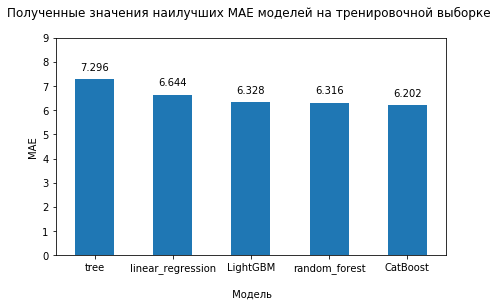

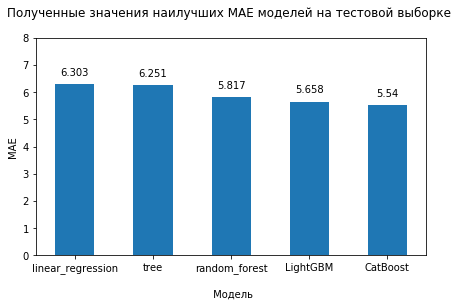

In [180]:
ax = model_results['mae_train'].sort_values(ascending=False).plot(kind='bar', rot=0, figsize=(7,4))
ax.set_ylabel('MAE')
ax.set_xlabel('\n Модель')
ax.set_title('Полученные значения наилучших MAE моделей на тренировочной выборке \n')
ax.set_ylim(0,round(1.2*max(model_results.loc[:,'mae_train'])))
for i, model in enumerate(model_results['mae_train'].sort_values(ascending=False).index):
    ax.text(
        i, model_results.loc[model,'mae_train']+0.05*max(model_results.loc[:,'mae_train']), 
        model_results.loc[model,'mae_train'], 
        horizontalalignment='center')
plt.show()

ax = model_results['mae_test'].sort_values(ascending=False).plot(kind='bar', rot=0, figsize=(7,4))
ax.set_ylabel('MAE')
ax.set_xlabel('\n Модель')
ax.set_title('Полученные значения наилучших MAE моделей на тестовой выборке \n')
ax.set_ylim(0,round(1.2*max(model_results.loc[:,'mae_test'])))
for i, model in enumerate(model_results['mae_test'].sort_values(ascending=False).index):
    ax.text(
        i, model_results.loc[model,'mae_test']+0.05*max(model_results.loc[:,'mae_test']), 
        model_results.loc[model,'mae_test'], 
        horizontalalignment='center')  
plt.show()

Наилучший результат MAE на тренировочных данных показала модель CatBoost (6.20), случайный лес (6.316), LightGBM (6.328). На тестовых данных тройка лидеров та же: CatBoost (5.54), LightGBM (5.658), случайный лес (5.817). Предсказания всех моделей лучше MAE константной модели, составляющей 8.224, что говорит об адекватности полученных моделей.

### Вывод

На данном этапе были созданы, обучены модели и получены предсказания.
Признаки для моделей cлучайного леса, LightGBM, CatBoost были проверены на важность, и в дальнейшем обучении для каждой из этих моделей использованы признаки с важностью не менее 1%. Гиперпараметры моделей были найдены с помощью поиска по сетке GridSearchCV с разбиением данных для кросс-валидации на 3 части. Далее модели были обучены с найденными гиперпараметрами и получена метрика MAE для обучающей и тестовой выборки. Наилучшее значение MAE показала модель CatBoost со значением  6.20 на обучающей, 5.54 на тестовой выборке. Эта модель рекомендуется для использования в предсказании температуры на данном этапе технологического процесса компании ООО «Так закаляем сталь». 